In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%matplotlib notebook

<IPython.core.display.Javascript object>


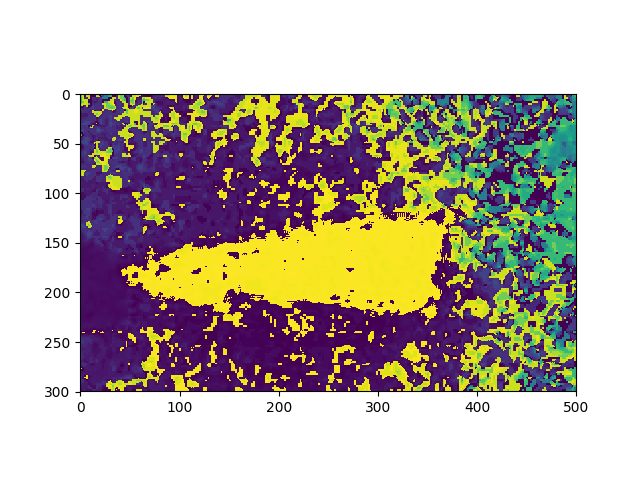

<IPython.core.display.Javascript object>


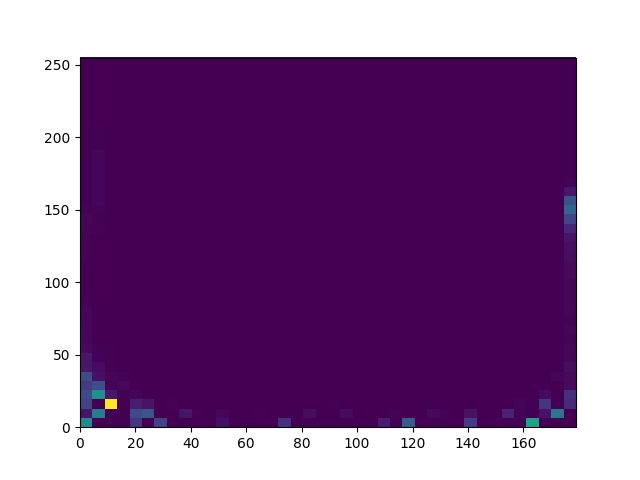

(array([[  7.81000000e+03,   9.09000000e+02,   3.31500000e+03, ...,
           0.00000000e+00,   0.00000000e+00,   2.00000000e+00],
        [  0.00000000e+00,   6.77700000e+03,   1.90000000e+01, ...,
           1.00000000e+01,   4.00000000e+00,   2.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   1.61660000e+04, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        ..., 
        [  0.00000000e+00,   8.12000000e+02,   2.44100000e+03, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   6.32600000e+03,   0.00000000e+00, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   1.90700000e+03, ...,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00]]),
 array([   0.   ,    4.475,    8.95 ,   13.425,   17.9  ,   22.375,
          26.85 ,   31.325,   35.8  ,   40.275,   44.75 ,   49.225,
          53.7  ,   58.175,   62.65 ,   67.125,   71.6  

In [4]:
imbgr = cv2.imread('/home/ori/Pictures/20180405_132057_HDR.jpg')

imhsv = cv2.cvtColor(imbgr, cv2.COLOR_BGR2HSV)

ROI = imhsv[1200:1500,2000:2500]

plt.figure()
plt.imshow(ROI[:,:,0]);

plt.figure()
plt.hist2d(list(ROI[:,:,0].flat),list(ROI[:,:,1].flat),bins=40)


In [5]:
def get_plain_mask(ROI):
    maskH = ROI[:,:,0]>170
    maskS = ROI[:,:,1]>100

    mask = np.bitwise_and(maskH,maskS)
    return mask


<class 'numpy.bool_'>


<IPython.core.display.Javascript object>


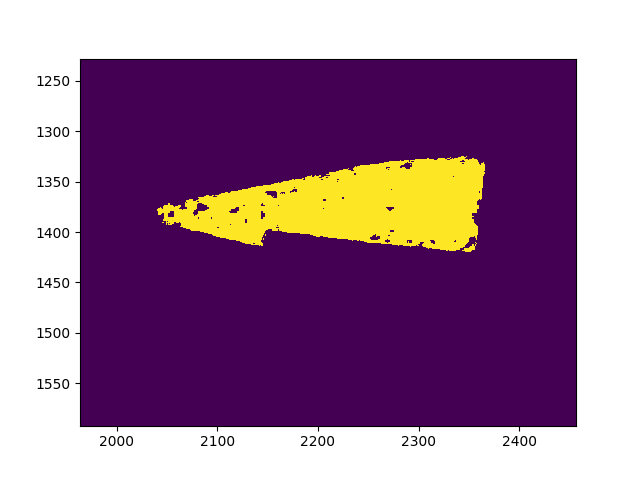

In [50]:
mask = get_plain_mask(imhsv)
plt.figure()
plt.imshow(mask)

<IPython.core.display.Javascript object>


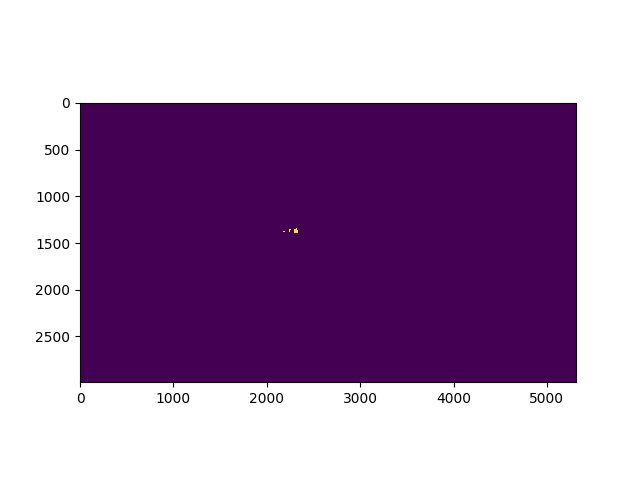

In [55]:
eroded = cv2.erode(np.uint8(mask), np.ones((16,16)),iterations=2)

plt.figure()
plt.imshow(eroded)

<IPython.core.display.Javascript object>


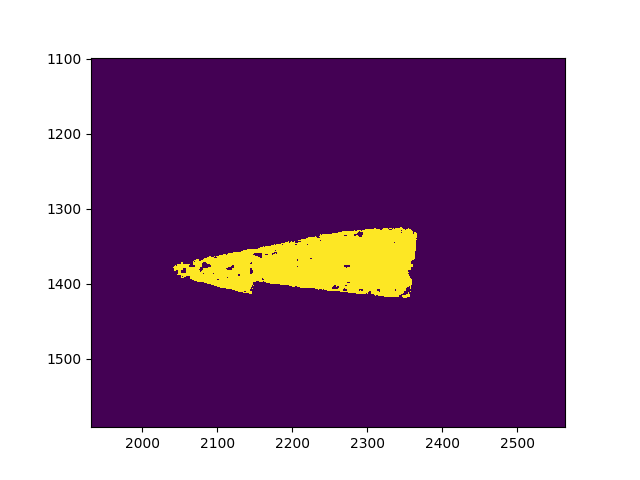

In [7]:
umask = np.uint8(mask) * 255
plt.figure()
plt.imshow(umask)

<IPython.core.display.Javascript object>


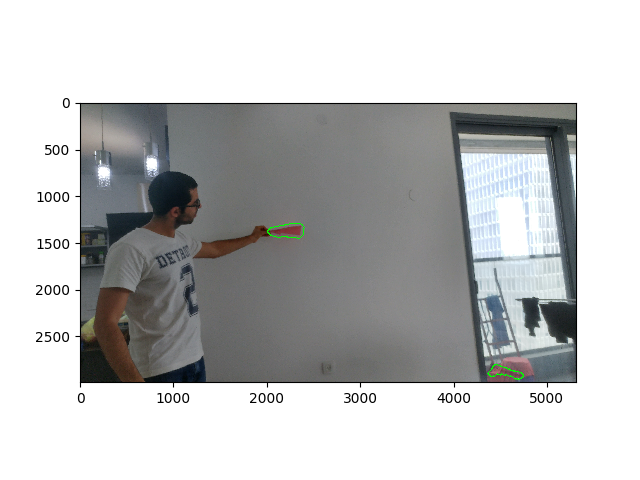

In [113]:
_, contours, _ = cv2.findContours(umask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

'''
print(len(contours))
for c in contours:
    m = cv2.moments(c)
    cX = int(m['m10'] / m['m00'])
    cY = int(m['m01'] / m['m00'])
    print(cv2.contourArea(c), cX, cY)
'''

filtered_contours = [c for c in contours if cv2.contourArea(c) > 25000]
res_im = cv2.drawContours(cv2.cvtColor(imbgr, cv2.COLOR_BGR2RGB), filtered_contours, -1, (0,255,0), 10)

plt.figure()
plt.imshow(res_im)

<IPython.core.display.Javascript object>


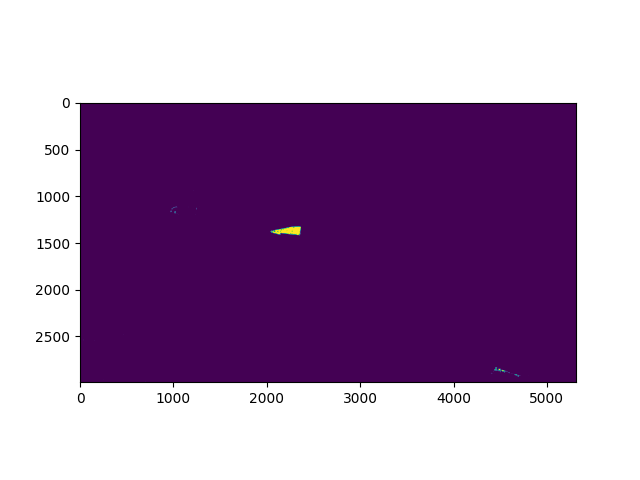

9.154537200927734 (2083.821044921875, 1376.5860595703125)
11.252677917480469 (2117.8486328125, 1379.4501953125)
2


In [80]:
blurred = cv2.blur(umask, (12,12))
plt.figure()
plt.imshow(blurred)

params = cv2.SimpleBlobDetector_Params()
params.minArea = 40
params.filterByInertia = True
params.minInertiaRatio = 0.01

detector = cv2.SimpleBlobDetector_create(params)
keypoints = detector.detect(blurred)
for kp in keypoints:
    print(kp.size, kp.pt)
print(len(keypoints))

<IPython.core.display.Javascript object>


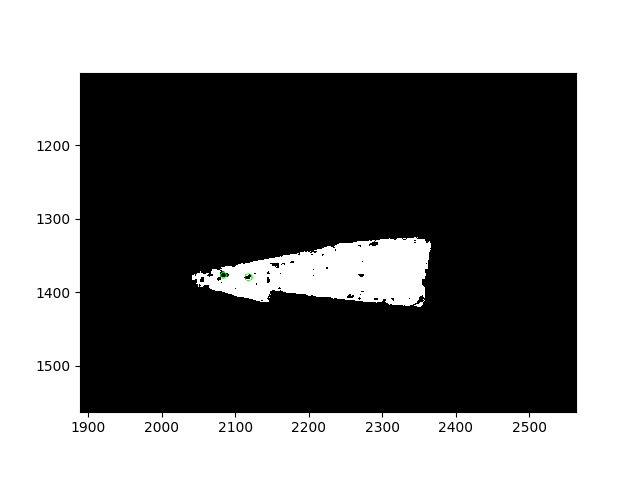

In [78]:
im_with_keypoints = cv2.drawKeypoints(umask, keypoints, np.array([]), (0, 255, 0),
                                      cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure()
plt.imshow(im_with_keypoints)

In [33]:
mser = cv2.MSER_create()
regions = mser.detectRegions(umask, None)

In [ ]:
vis = imhsv.copy()
cv2.polylines(vis, regions, 1, (255,0,0), thickness=10)

1
98.5
88.5
72.0
826.0
484.0
410.5
214.0
134.5


<IPython.core.display.Javascript object>


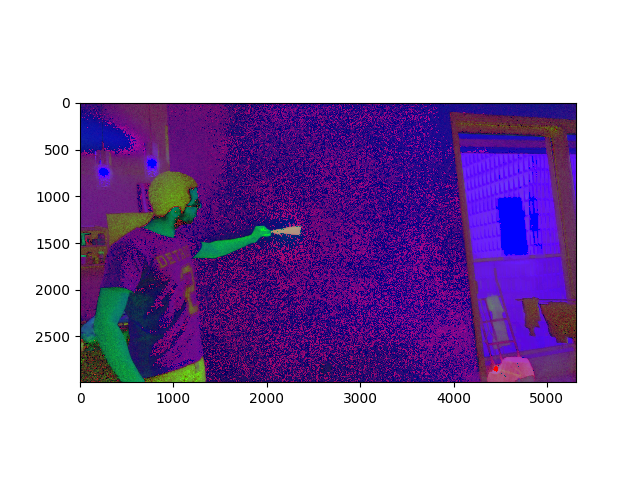

In [48]:
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]
big_hulls = [p for p in hulls if cv2.contourArea(p) > 500]
print(len(big_hulls))
for p in hulls:
    print(cv2.contourArea(p))
vis = imhsv.copy()
cv2.polylines(vis, big_hulls, 1, (255, 0, 0), thickness=20)
plt.figure()
plt.imshow(vis)

In [63]:
def center_of_mass(bool_im):
    return np.average(bool_im.nonzero(), axis=1)